Объединенный датасет доступен по [ссылке](https://drive.google.com/drive/folders/1jmxG2zfi-Fs3m2KrMGmjD347aYiT8YFM?usp=sharing).

Положить в папку data содержимое так, чтобы были следующие пути:  
* \$(ROOT_DIR)/data/merged-rtsd/...
* \$(ROOT_DIR)/data/gt.csv

> *gt_Set_NaN.csv - содержит тот же датасет, но значения колонки Set обнулено*

gt - датафрейм содержащий:  
* имена файлов - поле filename
* класс знака - поле sign_class
* флаг присутствия знака при работе с датасетом - IsPresent. Предполагается, что вместо удаления записи, будет устанавливатся этот флаг, включающий/не влючающий знак в выборку
* в какой набор включен знак - поле Set $\in$ $\{train, valid, test\}$

~~\# !gdown --id '1eKNfEuNQadRW1H4NOoMw5sdnyHV14ze0'
\# !unzip rtsd-r3.zip
\# !rm -rf rtsd-r3.zip~~

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Читаем данные, настраиваем дирректории. Инклудим *utils.ipynb*.

,filename,sign_class,is_present,set
0,000000.png,2_1,1,NaN
1,000001.png,2_1,1,NaN
2,000002.png,2_1,1,NaN
3,000003.png,2_1,1,NaN
4,000004.png,1_23,1,NaN
...,...,...,...,...
93649,093649.png,5_15_5,1,NaN
93650,093650.png,5_15_5,1,NaN
93651,093651.png,5_15_5,1,NaN
93652,093652.png,5_15_5,1,NaN


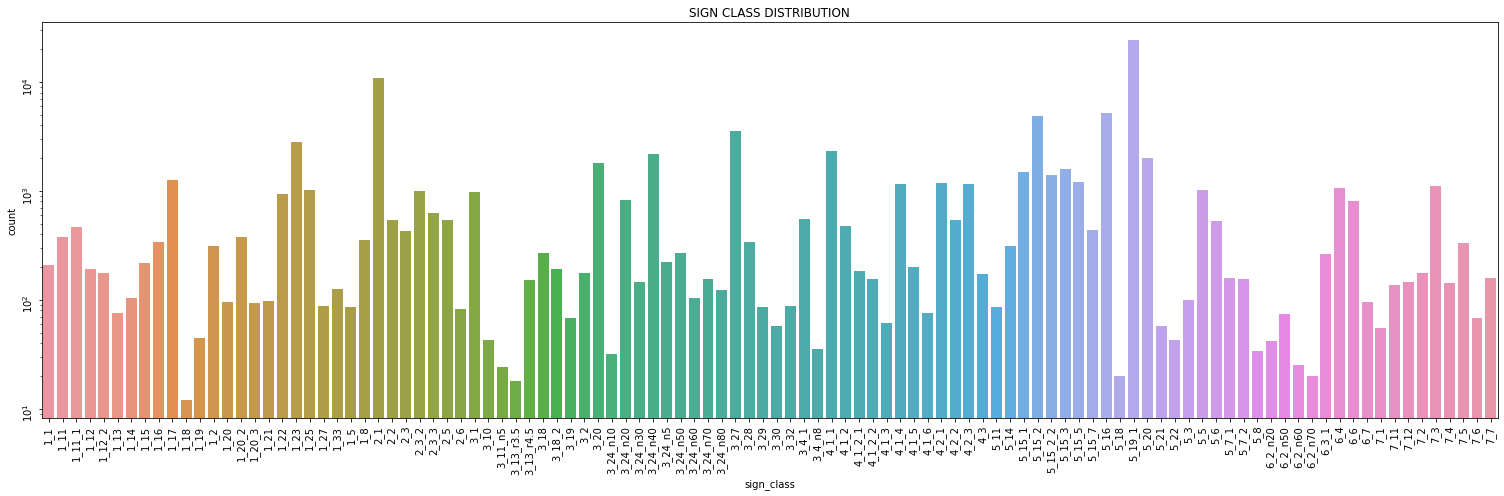

In [2]:
%run utils.ipynb
PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
DATA_DIR = PROJECT_ROOT / 'data'

gt = pd.read_csv(DATA_DIR / 'gt.csv')
GT_SRC_LEN = len(gt.index)
display(gt)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(21, 7))
ax.tick_params(labelrotation=90)

g = sns.countplot(x='sign_class', data=gt,  order=sorted(gt['sign_class'].value_counts().index.tolist()));
g.set_yscale("log")
ax.set_title('SIGN CLASS DISTRIBUTION')
plt.tight_layout()

Выкинем все неинтересующие классы.  

Progress: 93654/93654 (100.00%)
[!] These signs were not included: 
 {'2_4', '3_24_n110', '3_23', '3_24_n90', '3_21', '3_24_n120', '3_31', '3_24_n130', '1_6', '3_24_n100', '6_3_2', '1_31', '3_22', '3_25'}


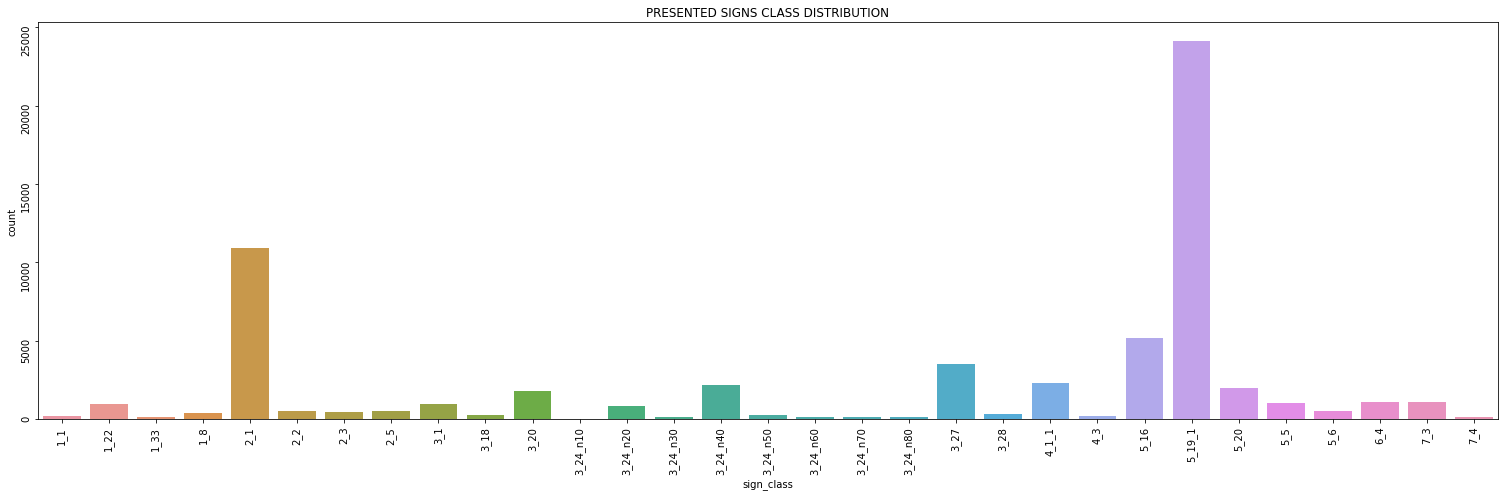

In [3]:
if len(gt['set'].unique()) == 1:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    
    INCLUDED_CLASSES = set()
    IS_PRESENT_COLUMN_INDEX = gt.columns.get_loc("is_present")
    
    for row in gt.itertuples():

        if row.sign_class in CLASSES:          
            INCLUDED_CLASSES.add(row.sign_class)
        else:
            gt.iat[row.Index, IS_PRESENT_COLUMN_INDEX] = 0

        if (row.Index % 500 == 0) or (row.Index + 1 == GT_SRC_LEN):
            printProgressEnum(row.Index, GT_SRC_LEN)
            
    NOT_INCLUDED_SIGNS = set(CLASSES) - INCLUDED_CLASSES
    if NOT_INCLUDED_SIGNS:
        print('\n[!] These signs were not included: \n', NOT_INCLUDED_SIGNS)
        
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(21, 7))
ax.tick_params(labelrotation=90)

g = sns.countplot(x='sign_class', data=gt[gt['is_present']==1],  order=sorted(gt[gt['is_present']==1]['sign_class'].value_counts().index.tolist()));
ax.set_title('PRESENTED SIGNS CLASS DISTRIBUTION')
plt.tight_layout()

UNDERSAMPLING_COMPLITED = False
OVERSAMPLING_COMPLITED = False

Сплитим по возможности в таком соотношении 20:20:60.  
Проблема - одного класса сильно больше чем другого.
Используем комбинацию методов, описанных [тут](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets?scriptVersionId=1756536&cellId=11): применим undersampling до среднего количества по группам. В недостающих группах докинем oversampling'ом.

Stage 1: UNDERSAMPLING ALL BY MEAN VALUE_COUNTS
Stage 1: UNDERSAMPLING COMPLITED
total ~NaN values in [set]: 62456
total [is_present]==1: 62456


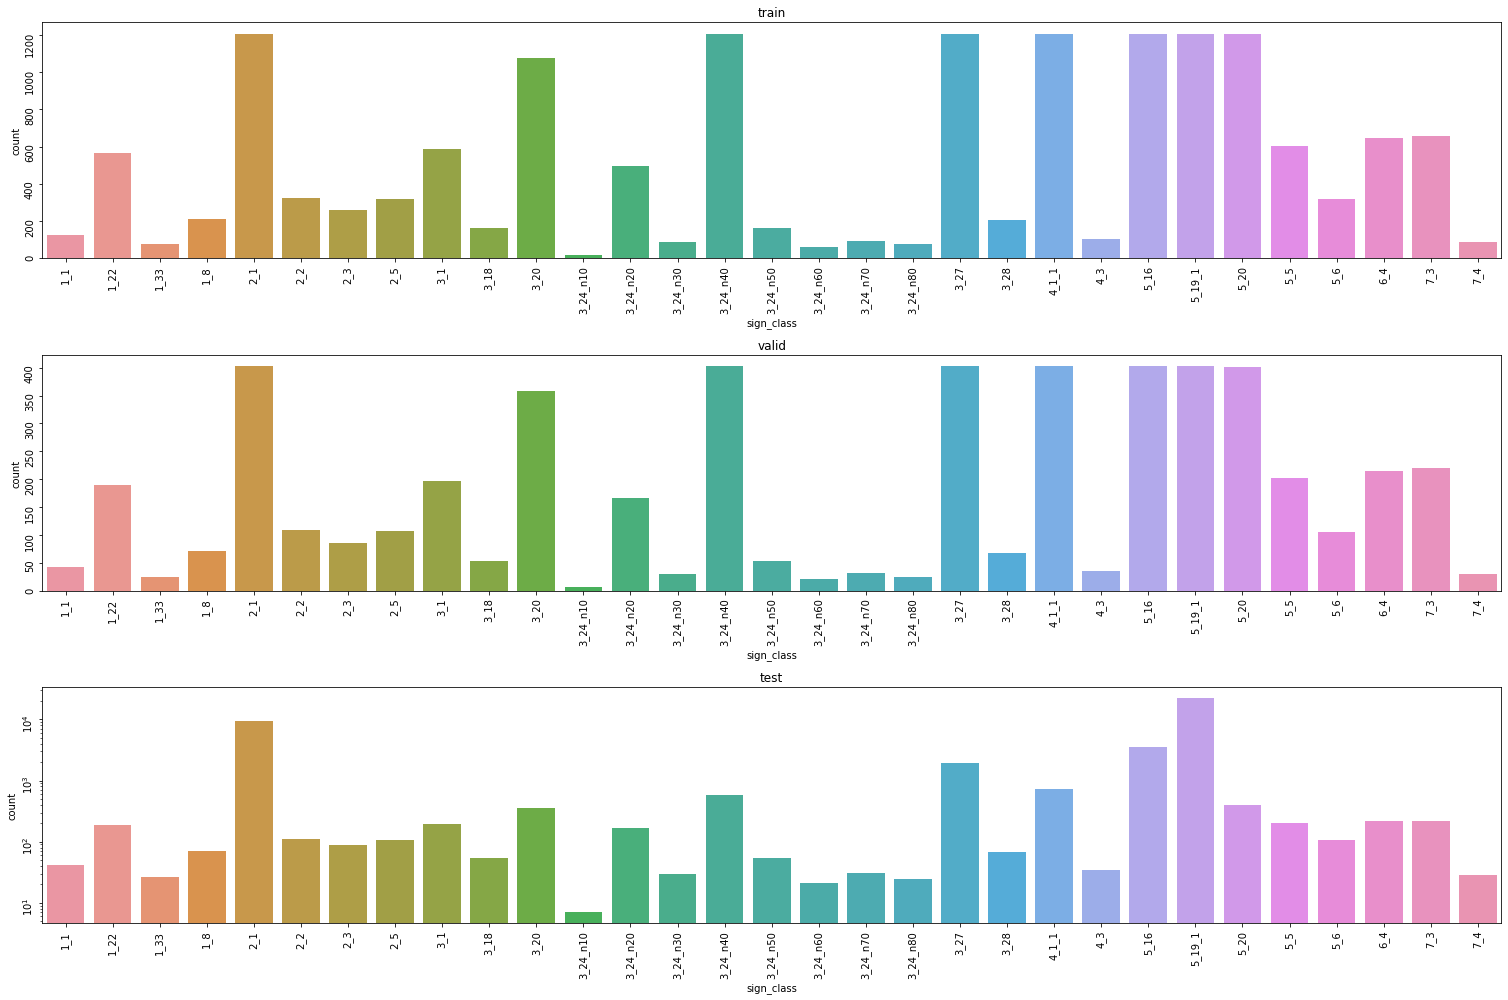

In [4]:
print('Stage 1: UNDERSAMPLING ALL BY MEAN VALUE_COUNTS')

if UNDERSAMPLING_COMPLITED == False:
    gt_present = gt[gt['is_present']==1]
    gt_present_grouped = gt_present.groupby('sign_class', axis=0)
    MEAN_BY_GROUPS = int(np.floor(gt_present_grouped.size().mean()))

    SET_COLUMN_INDEX = gt.columns.get_loc("set")

    for key, items in gt_present_grouped.groups.items():
        # print(items)
        items = list(items)     # явно приведем к списку для душевного спокойствия
        random.shuffle(items)   # перемешаем

        # print(key)

        if len(items) > MEAN_BY_GROUPS:
            # выбираем рандомные значения из этой группы в колличестве MEAN_BY_GROUPS*0.6 для train
            # MEAN_BY_GROUPS*0.2 для valid, остальное кинем в test
            # print(int(MEAN_BY_GROUPS*0.8))
            TEMP_ITEMS_INCLUDED = items[0:MEAN_BY_GROUPS]
            TEMP_ITEMS_EXCLUDED = items[MEAN_BY_GROUPS::]
            TRAIN_GROUP, VALID_GROUP, TEST_GPOUP = np.split(TEMP_ITEMS_INCLUDED, [int(len(TEMP_ITEMS_INCLUDED)*0.6), int(len(TEMP_ITEMS_INCLUDED)*0.8)])
            TEST_GPOUP = np.append(TEST_GPOUP, TEMP_ITEMS_EXCLUDED)
            #if key == '3_24_n40':
            #    print('TRAIN', sorted(TRAIN_GROUP), '\nVALID', sorted(VALID_GROUP), '\nTEST', sorted(TEST_GPOUP))
            #    # print('t', len(TRAIN_GROUP), 'v', len(VALID_GROUP), 't', len(TEST_GPOUP))
        else:
            TRAIN_GROUP, VALID_GROUP, TEST_GPOUP = np.split(items, [int(len(items)*0.6), int(len(items)*0.8)])
            # print('t', len(TRAIN_GROUP), 'v', len(VALID_GROUP), 't', len(TEST_GPOUP), '\n')
            # print('t', TRAIN_GROUP, 'v', VALID_GROUP, 't', TEST_GPOUP, '\n')    


        gt.iloc[TRAIN_GROUP, SET_COLUMN_INDEX] = 'train'
        gt.iloc[VALID_GROUP, SET_COLUMN_INDEX] = 'valid'
        gt.iloc[TEST_GPOUP, SET_COLUMN_INDEX] = 'test'
    
    print('Stage 1: UNDERSAMPLING COMPLITED')
    UNDERSAMPLING_COMPLITED = True
else:
    print('[!] Stage 1: UNDERSAMPLING ALREADY COMPLITED')

print('total ~NaN values in [set]:',gt['set'].value_counts().sum())
print('total [is_present]==1:', len(gt[gt['is_present']==1].index))
assert len(gt[gt['is_present']==1].index) == gt['set'].value_counts().sum()



_, ax = plt.subplots(nrows=3, ncols=1, figsize=(21, 14))

LABELS = ['train', 'valid', 'test']
for i in range(len(LABELS)):
    g = sns.countplot(x='sign_class', data=gt[gt['set']==LABELS[i]],  ax=ax[i], order=sorted(gt[gt['is_present']==1]['sign_class'].value_counts().index.tolist()));
    ax[i].tick_params(labelrotation=90)
    ax[i].set_title(LABELS[i])
    plt.tight_layout()
    
ax[2].set_yscale("log")

Stage 2: OVERSAMPLING TRAIN
Stage 2: OVERSAMPLING COMPLITED


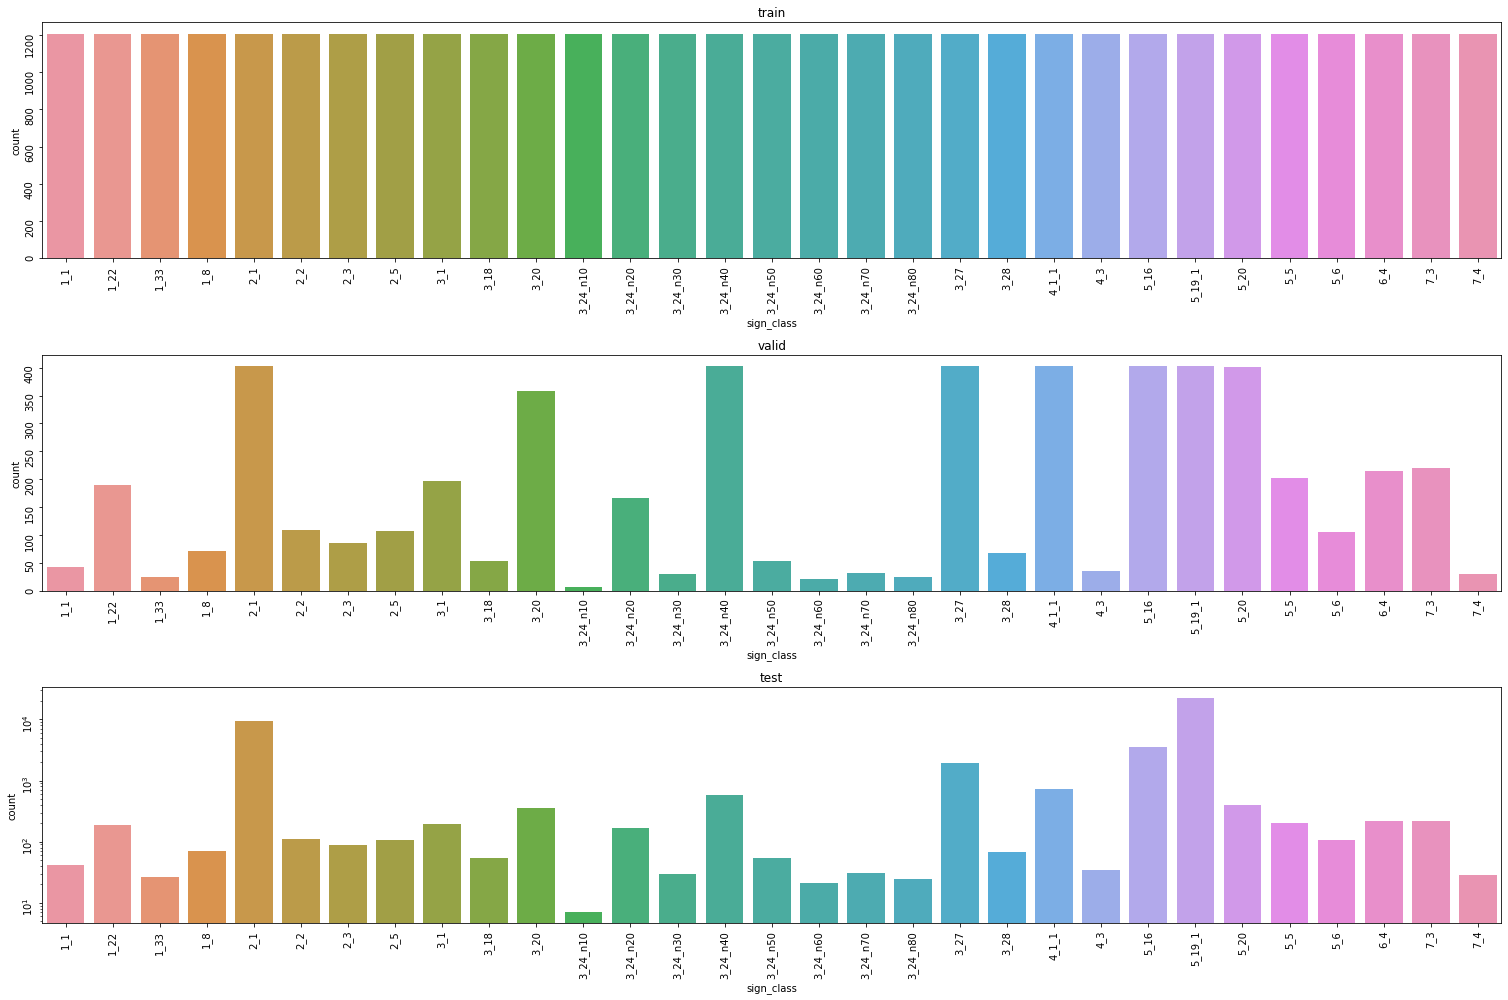

In [5]:
print('Stage 2: OVERSAMPLING TRAIN')

if OVERSAMPLING_COMPLITED == False:
    gt_present = gt[gt['set']=='train']
    gt_present_grouped = gt_present.groupby('sign_class', axis=0)

    for key, items in gt_present_grouped.groups.items():

        items = list(items)     # явно приведем к списку для душевного спокойствия
        random.shuffle(items)   # перемешаем
        # print(len(items))
        if len(items) < MEAN_BY_GROUPS:
            ROWS_TO_FILL_COUNT = int(MEAN_BY_GROUPS*0.6) - len(items)
            ROWS_TO_APPEND = gt.iloc[items].sample(ROWS_TO_FILL_COUNT, replace=True)
            # print(ROWS_TO_APPEND)
            #print(len(gt.index))
            gt = gt.append(ROWS_TO_APPEND, ignore_index=True)
            #print(len(gt.index))
            
    print('Stage 2: OVERSAMPLING COMPLITED')
    OVERSAMPLING_COMPLITED = True
else:
    print('[!] Stage 2: OVERSAMPLING ALREADY COMPLITED')
    
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(21, 14))

LABELS = ['train', 'valid', 'test']
for i in range(len(LABELS)):
    g = sns.countplot(x='sign_class', data=gt[gt['set']==LABELS[i]],  ax=ax[i], order=sorted(gt[gt['is_present']==1]['sign_class'].value_counts().index.tolist()));
    ax[i].tick_params(labelrotation=90)
    ax[i].set_title(LABELS[i])
    plt.tight_layout()
    
ax[2].set_yscale("log")

In [6]:
MODEL_CLASSES = sorted(list(INCLUDED_CLASSES))
from sklearn import preprocessing
MODEL_LABEL_ENCODER = preprocessing.LabelEncoder()

MODEL_CLASSES_TARGETS = MODEL_LABEL_ENCODER.fit_transform(MODEL_CLASSES)
MODEL_CLASS_MAP = dict(zip(MODEL_CLASSES, MODEL_CLASSES_TARGETS))
MODEL_CLASS_UNMAP = dict(zip(MODEL_CLASSES_TARGETS, MODEL_CLASSES))

class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, directory, set_label):
        # print((df['is_present'] == 1) & (df['set']==set_label))
        self.df = df[(df['is_present'] == 1) & (df['set']==set_label)]
        self.dir = directory
        # print(self.df.head(50))
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index):
        label = self.df.iloc[index]['sign_class']
        path = self.dir / self.df.iloc[index]['filename']
        # print(path)
        img = cv2.imread(str(path), )
        # plt.imshow(img)
        # plt.show()
        img = cv2.resize(img, (160, 160))
        # print(img)
        img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
        # print(label)
        encoded_label = MODEL_CLASS_MAP[label]
        # print(encoded_label)
        return img_tnsr, encoded_label
    
train_dataset = SignDataset(gt, DATA_DIR / 'merged-rtsd', 'train')
valid_dataset = SignDataset(gt, DATA_DIR / 'merged-rtsd', 'valid')
test_dataset = SignDataset(gt, DATA_DIR / 'merged-rtsd', 'test')

batch_size = 8

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)

valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)

In [ ]:
%run utils.ipynb

config = {
    'lr': 0.0001,
    'epochs': 150,
}

from torchvision import models, transforms as transforms
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, len(MODEL_CLASSES))

loss_op = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adadelta(model.parameters(), lr=config['lr'])

if os.path.isfile('resnet18_rtsd_test'):
    model.load_state_dict(torch.load('resnet18_rtsd_test'))
    print('[+] Model restored from save file!')

history = {
    'train_loss': [],
    'valid_acc': []
}

import shutil
from datetime import datetime

model.to(device)
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
%matplotlib inline

from IPython.display import clear_output

for epoch in range(config['epochs']):
    
    history['train_loss'].append(train_epoch(model, train_loader, loss_op, optim, device))

    print(f'Epoch {epoch}:')
    print('  Train loss:', history['train_loss'][-1])

    history['valid_acc'].append(valid_epoch(model, train_loader, device))
    # model.incIter()
    print('  Valid acc:', history['valid_acc'][-1])
    
    now = datetime.now()
    model_save_name = 'resnet18_rtsd_test_{}_loss{:.4f}_acc_{:.4f}'.format(now.strftime("%m.%d_%H.%M"),
                                                                  history['train_loss'][-1],
                                                                  history['valid_acc'][-1])    
    torch.save(model.state_dict(), model_save_name)
    # shutil.copy2(model_save_name, '/content/gdrive/MyDrive/MastersD/RTSD_dataset+/rtsd-r3/')

    # torch.save(model.state_dict(), 'resnet18_rtsd_test')
    # shutil.copy2('resnet18_rtsd_test', '/content/gdrive/MyDrive/MastersD/RTSD_dataset+/rtsd-r3/')
    

print(history)

Epoch 0:
  Train loss: -1
  Valid acc: -3
Epoch 1:
  Train loss: -1
  Valid acc: -3
Epoch 2:
  Train loss: -1
  Valid acc: -3
Epoch 3:
  Train loss: -1
  Valid acc: -3
Epoch 4:
  Train loss: -1
  Valid acc: -3
Epoch 5:
  Train loss: -1
  Valid acc: -3
Epoch 6:
  Train loss: -1
  Valid acc: -3
Epoch 7:
  Train loss: -1
  Valid acc: -3
Epoch 8:
  Train loss: -1
  Valid acc: -3
Epoch 9:
  Train loss: -1
  Valid acc: -3
Epoch 10:
  Train loss: -1
  Valid acc: -3
Epoch 11:
  Train loss: -1
  Valid acc: -3
Epoch 12:
  Train loss: -1
  Valid acc: -3
Epoch 13:
  Train loss: -1
  Valid acc: -3
Epoch 14:
  Train loss: -1
  Valid acc: -3
Epoch 15:
  Train loss: -1
  Valid acc: -3
Epoch 16:
  Train loss: -1
  Valid acc: -3
Epoch 17:
  Train loss: -1
  Valid acc: -3
Epoch 18:
  Train loss: -1
  Valid acc: -3
Epoch 19:
  Train loss: -1
  Valid acc: -3
Epoch 20:
  Train loss: -1
  Valid acc: -3
Epoch 21:
  Train loss: -1
  Valid acc: -3
Epoch 22:
  Train loss: -1
  Valid acc: -3
Epoch 23:
  Train los

In [ ]:
def showTensorPicture(tensor_image, label=None):
    img = tensor_image.permute(1, 2, 0)
    img = cv2.cvtColor(tensor_image.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()
    
    
img_t, label_e = test_dataset[8]
showTensorPicture(img_t, label=MODEL_CLASS_UNMAP[label_e])
print(MODEL_CLASS_UNMAP[label_e])

In [ ]:
def showTensorPicture(tensor_image):
    plt.imshow(tensor_image.permute(1, 2, 0))

In [ ]:
from google.colab import files
files.download("/content/merged.zip")

In [ ]:
gt = pd.concat([gt_train, gt_test_copy])
gt['Set'] = pd.Series([None for x in range(len(gt.index))])

In [ ]:
gt_test_copy = gt_test.copy()
for index, row in gt_test_copy.iterrows():
  # print(row)
  target_filename = incrementFile(row['filename'], inc_val)
  print(row['filename'], '->', target_filename)

  gt_test_copy.loc[index, 'filename'] = incrementFile(row['filename'], inc_val)

In [ ]:
display(gt_test)
display(gt_train)
print(inc_val)

In [ ]:
!ls rtsd-r3/data/ALL